In [ ]:
data = pd.merge(train_perf,train_prev,how='outer', on=['customerid'])
df = pd.merge(data,train_demo,how='outer', on=['customerid'])
df_ = df.drop(['customerid','systemloanid_x','systemloanid_y','longitude_gps','latitude_gps'],axis=1)
clean_train = df_.dropna()

print('Merged data shape: ',clean_train.shape)

clean_train.head()
#clean_data.good_bad_flag.plot(kind='hist')

In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

## Supporting Functions

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(
        ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(10)
    
def dup_label(df,label,val,n):
    temp = df[df[label] == val]
    for _ in range(n):
        df = df.append(temp,ignore_index=True)
    return df

def submission_to_csv(data,y_pred):
    data = np.column_stack((data['customerid'].values,y_pred))
    submission = pd.DataFrame(data,columns = ['customerid','Good_Bad_flag'])
    submission.to_csv(os.getcwd()+'\\dataset\\submission.csv',index = False)
    return "Conversion complete!"


## Cleaning Functions

In [3]:
def clean_demo(df):
    date = dt.now()
    df.birthdate = pd.to_datetime(df.birthdate)
    df['Age'] = date.year - df.birthdate.apply(lambda x:x.year)
    #df.employment_status_clients.fillna('others',inplace=True)
    #df.replace({'employment_status_clients':{'Self-Employed':1,'Student':1,'Unemployed':1,
                                                         #'Retired':1,'Contract':1,'n/a':1,'Permanent':2}},inplace=True)

    #df.replace({'bank_account_type':{'Current':1,'Other':2,'Savings':3}},inplace=True)
    df.drop_duplicates(inplace=True)
    demo = df.drop(['bank_branch_clients','level_of_education_clients','bank_name_clients','birthdate'],axis=1)
    return demo

def clean_prev(df):
    df['referredby'] = df['referredby'].fillna(0)
    df['referredby'] = df['referredby'].apply(lambda x : 0 if x==0 else 1)

    df['Interest'] = df.totaldue - df.loanamount
    df.replace({'termdays':{15:1,30:2,60:3,90:4}},inplace=True)
    df.firstrepaiddate = pd.to_datetime(df.firstrepaiddate)
    df.firstduedate = pd.to_datetime(df.firstduedate)
    repay_delta = df.firstrepaiddate - df.firstduedate
    repay_delta = repay_delta.apply(lambda x:x.days)

    df['lag_time'] = repay_delta.apply(lambda x: x if x>0 else 0)
    prev = df.drop(['approveddate','creationdate','loanamount','totaldue','closeddate','firstduedate','firstrepaiddate'],axis=1)
    return prev

def clean_perf(df):
    df['referredby'] = df['referredby'].fillna(0)
    df['referredby'] = df['referredby'].apply(lambda x : 0 if x==0 else 1)
    df['Interest'] = df.totaldue - df.loanamount
    perf = df.drop(['approveddate','creationdate','loanamount','totaldue'],axis=1)
    return perf

def merge_data(perf,prev,demo):
    data = pd.merge(perf,prev,how='left', on=['customerid','referredby'])
    df = pd.merge(data,demo,how='left', on=['customerid'])
    train_clean_data = df.sort_values('loannumber_y',ascending=False).drop_duplicates('customerid').sort_index().reset_index(drop=True)
    clean_train = train_clean_data.drop(['customerid','systemloanid_x','systemloanid_y','longitude_gps','latitude_gps'],axis=1)

    return clean_train
    



## Datasets

In [4]:
train_perform = pd.read_csv('dataset/trainperf.csv')
train_prevloans = pd.read_csv('dataset/trainprevloans.csv')
train_demographics = pd.read_csv('dataset/traindemographics.csv')

test_demographics = pd.read_csv('dataset/testdemographics.csv')
test_perform = pd.read_csv('dataset/testperf.csv')
test_prevloans = pd.read_csv('dataset/testprevloans.csv')

## Cleaning of Demographics Data

In [5]:
print('Train_demographics: ',str(train_demographics.shape))
duplicates = train_demographics.shape[0] - train_demographics.drop_duplicates().shape[0]
print('Train_demographics duplicate rows: ',str(duplicates))

print('Test_demographics: ',str(test_demographics.shape))
duplicates = test_demographics.shape[0] - test_demographics.drop_duplicates().shape[0]
print('Test_demographics duplicate rows: ',str(duplicates))

train_demo = clean_demo(train_demographics)
test_demo = clean_demo(test_demographics)

Train_demographics:  (4346, 9)
Train_demographics duplicate rows:  12
Test_demographics:  (1487, 9)
Test_demographics duplicate rows:  3


## Cleaning of Train prevloans

In [6]:
print('Train_prev: ',str(train_prevloans.shape))
duplicates = train_prevloans.shape[0] - train_prevloans.drop_duplicates().shape[0]
print('Train_prev duplicate rows: ',str(duplicates))

print('Test_prev: ',str(test_prevloans.shape))
duplicates = test_prevloans.shape[0] - test_prevloans.drop_duplicates().shape[0]
print('Test_prev duplicate rows: ',str(duplicates))

train_prev = clean_prev(train_prevloans)
test_prev = clean_prev(test_prevloans)


Train_prev:  (18183, 12)
Train_prev duplicate rows:  0
Test_prev:  (5907, 12)
Test_prev duplicate rows:  0


## Cleaning of Train Perf

In [7]:
print('Train_perf: ',str(train_perform.shape))
duplicates = train_perform.shape[0] - train_perform.drop_duplicates().shape[0]
print('Train_perf duplicate rows: ',str(duplicates))

print('Test_perf: ',str(test_perform.shape))
duplicates = test_perform.shape[0] - test_perform.drop_duplicates().shape[0]
print('Test_perf duplicate rows: ',str(duplicates))


train_perf = clean_perf(train_perform)
test_perf = clean_perf(test_perform)

train_perf.replace({'good_bad_flag':{'Good':1,'Bad':0}},inplace=True)



Train_perf:  (4368, 10)
Train_perf duplicate rows:  0
Test_perf:  (1450, 9)
Test_perf duplicate rows:  0


## Data Merging on train set

In [8]:
clean_train = merge_data(train_perf,train_prev,train_demo)
print('Merged data shape: ',clean_train.shape)

clean_train.loannumber_y.fillna(clean_train.loannumber_y.median(),inplace=True)
clean_train.termdays_y.fillna(clean_train.termdays_y.median(),inplace=True)
clean_train.Interest_y.fillna(clean_train.Interest_y.mean(),inplace=True)
clean_train.lag_time.fillna(clean_train.lag_time.median(),inplace=True)
clean_train.bank_account_type.fillna('others',inplace=True)
clean_train.employment_status_clients.fillna('others',inplace=True)
clean_train.Age.fillna(clean_train.Age.median(),inplace=True)

#clean_train = clean_train.drop(['referredby'],axis=1)


Merged data shape:  (4368, 12)


## Data merging on Kaggle test set

In [9]:
clean_test = merge_data(test_perf,test_prev,test_demo)
print('Merged data shape: ',clean_test.shape)

clean_test.loannumber_y.fillna(clean_test.loannumber_y.median(),inplace=True)
clean_test.termdays_y.fillna(clean_test.termdays_y.median(),inplace=True)
clean_test.Interest_y.fillna(clean_test.Interest_y.mean(),inplace=True)
clean_test.lag_time.fillna(clean_test.lag_time.median(),inplace=True)
clean_test.bank_account_type.fillna('others',inplace=True)
clean_test.employment_status_clients.fillna('others',inplace=True)
clean_test.Age.fillna(clean_test.Age.median(),inplace=True)

#clean_test = clean_test.drop(['referredby'],axis=1)

#print(clean_test.isnull().sum())
#clean_test.head()

Merged data shape:  (1450, 11)


## Checking correlation between the features and the target

In [10]:
clean_train.corr()['good_bad_flag'].sort_values(ascending=False)

good_bad_flag    1.000000
loannumber_x     0.090487
loannumber_y     0.090244
Interest_y       0.066434
Age              0.051313
termdays_y       0.040507
Interest_x       0.032540
termdays_x       0.005160
referredby      -0.009859
lag_time        -0.256516
Name: good_bad_flag, dtype: float64

## Train-Test Data Preparation

### Preparing train data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

#clean_train = dup_label(clean_train,'good_bad_flag',0,1)  ## Oversampling for the minority label

train_X = clean_train.drop(['good_bad_flag'],axis=1)

dum = pd.get_dummies(train_X,['employment_status_clients','bank_account_type'])
train_X = train_X.drop(['employment_status_clients','bank_account_type'],axis=1)
train_X = pd.concat((train_X,dum),axis=1)

train_X = train_X.drop(['bank_account_type_Contract'],axis=1) ## This is done because the contract category is not in the test data
n_cols = train_X.shape[1]
y = clean_train.good_bad_flag

X_train,X_test,y_train,y_test = train_test_split(train_X,y,test_size=0.3)

st = StandardScaler()
X_train_std = st.fit_transform(X_train)
X_test_std = st.transform(X_test)

### Preparing Kaggle Test Data

In [12]:
test_X = clean_test
dum = pd.get_dummies(test_X,['employment_status_clients','bank_account_type'])
test_X = test_X.drop(['employment_status_clients','bank_account_type'],axis=1)
test_X = pd.concat((test_X,dum),axis=1)
#clean_test = clean_test.drop(['loannumber_x','Interest_x','termdays_x','referredby','termdays_y'],axis=1)

st = StandardScaler()
test_X_std = st.fit_transform(test_X)

## Handling Data Imbalance

## Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler() 
X_resampled, y_resampled = rus.fit_sample(X_train_std, y_train) 

## Oversampling

In [ ]:
from imblearn.over_sampling import ADASYN 
ada = ADASYN() 
X_resampled, y_resampled = ada.fit_sample(X_train_std, y_train) 

## SMOTE plus KNN

In [14]:
from imblearn.combine import SMOTEENN 
smo = SMOTEENN() 
X_resampled, y_resampled = smo.fit_sample(X_train_std, y_train) 

## Model Training

After using the sampling techniques, the model performs less better than it did without the sampling techniques. This was only tested  for the logistic regression classifier. The oversampling and smote techniques performed bettr than the undersampling technique.

### Logistic Regression

Accurcacy Score:  0.6773455377574371


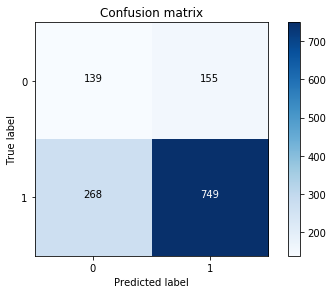

'Conversion complete!'

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1',C=10)
#clf.fit(X_train_std,y_train)
clf.fit(X_resampled, y_resampled)
print('Accurcacy Score: ',clf.score(X_test_std,y_test))

y_pred = clf.predict(X_test_std)

cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

## Classification of test data and preparation for submission
y_test_pred = clf.predict(test_X_std)
submission_to_csv(test_perform,y_test_pred)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gfr = GradientBoostingClassifier()
gfr.fit(X_train_std,y_train)
print('Accurcacy Score: ',gfr.score(X_test_std,y_test))

y_pred = gfr.predict(X_test_std)

cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

## Classification of test data and preparation for submission
y_test_pred = gfr.predict(test_X_std)
submission_to_csv(test_perform,y_test_pred)

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4)

tree.fit(X_train,y_train)
print('Accurcacy Score: ',tree.score(X_test_std,y_test))

y_pred = tree.predict(X_test_std)

cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

## Classification of test data and preparation for submission
y_test_pred = tree.predict(test_X_std)
submission_to_csv(test_perform,y_test_pred)

### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=20,max_depth=4)

forest.fit(X_resampled, y_resampled)
print('Accurcacy Score: ',forest.score(X_test_std,y_test))

y_pred = forest.predict(X_test_std)

cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

## Classification of test data and preparation for submission
y_test_pred = forest.predict(test_X_std)
submission_to_csv(test_perform,y_test_pred)

### Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.grid_search import GridSearchCV
predictors = [x for x in clean_train.columns if x not in ['good_bad_flag']]
estimators = [i for i in range(20,81,10)]
param_test1 = {'n_estimators': estimators}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=15,max_depth=4,max_features='sqrt', random_state=10), 
                       param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)
print('Accurcacy Score: ',gsearch1.score(X_test_std,y_test))

y_pred = forest.predict(X_test_std)

cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

## Classification of test data and preparation for submission
y_test_pred = forest.predict(test_X_std)
submission_to_csv(test_perform,y_test_pred)


In [ ]:
print('Best parameters: {}'.format(gsearch1.best_params_))

In [ ]:
gsearch1.grid_scores_, gsearch1.best_score_

### Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

def loan_classifier():
    model = Sequential()
    model.add(Dense(10,activation='relu',input_shape=(n_cols,)))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(2,activation='softmax'))

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

target_train = to_categorical(y_train)
target_test = to_categorical(y_test)

clf = loan_classifier()
clf.fit(X_train_std,target_train,validation_data=(X_test_std,target_test),epochs=100,verbose=0)

scores = clf.evaluate(X_test_std, target_test, verbose=0)
print('Accurcacy Score: ',scores[1])

y_pred = clf.predict_classes(X_test_std)

cnf_matrix = confusion_matrix(y_test,y_pred)
class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

## Classification of test data and preparation for submission
y_test_pred = clf.predict_classes(test_X_std)
submission_to_csv(test_perform,y_test_pred)
